# OCNG/ATMO 651 Final Project: Linear Inverse Model of Tropical Sea Surface Temperatures

## Dataset
NCEP/NCAR Reanalysis monthly-mean SST from 1948-01 to 2017-09

## Method

# 1. Read in data

Use xarray to read in the data. The data is in netCDF format.

In [1]:
import numpy.linalg as la
import xarray as xr
import numpy as np

def get_anomaly(x):
    """Remove the seasonal cycle from the data.
    Params: x (numpy array): data with time dimension
    Returns: x (numpy array): data with seasonal cycle removed
    """
    nt, ny, nx = x.shape
    x = x.reshape(nt//12, 12, ny, nx)
    # seasonal mean
    x_mean = x.mean(axis=0, keepdims=True)
    # remove seasonal cycle
    x = x - x_mean
    # reshape time dimension
    x = x.reshape(nt, ny, nx)
    return x

def running_mean(x, m):
    """Compute the running mean of x along the first dimension.
    Params: x (numpy array): data
            m (int): half of the window size
    Returns: x (numpy array): data with running mean
    """
    # reference:
    # https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
    nt, ny, nx = x.shape
    x_rm = np.zeros_like(x)
    # pad the data along the dimension dim with m elements
    pad_width = [(0, 0)]*x.ndim
    pad_width[0] = (m, m)
    x = np.pad(x, pad_width, mode='edge')
    # compute the running mean
    for j in range(ny):
        for i in range(nx):
            x_rm[:,j,i] = np.convolve(x[:,j,i], np.ones(2*m+1)/float(2*m+1), mode='valid')
    return x_rm

# read in the data
dir = "../NCEP_monthly_mean_data/"
sst_ds = xr.open_dataset(dir + "skt.sfc.mon.mean.tropics.nc", use_cftime=True)
grid_ds = xr.open_dataset(dir + "lsmask.tropics.nc", use_cftime=True)
# get the data
sst_da, grid_da = sst_ds.skt, grid_ds.lsmask
# reverse the latitude dimension to make it increasing
sst_da = sst_da.reindex(lat=sst_da.lat[::-1])
grid_da = grid_da.reindex(lat=grid_da.lat[::-1])
# select data from 1948 to 1999 for training, 
# and in a target region (30N-30S, 100E-60W)
lat_min, lat_max = -30, 30
lon_min, lon_max = 100, 300
sst = sst_da.sel(time=slice("1948", "1999"), lon=slice(lon_min, lon_max))
grid = grid_da.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
lat, lon = sst.lat.values, sst.lon.values
time = sst.time.values
# get the data as numpy arrays
sst, grid = sst.values, grid.values
grid = grid[0,:,:]
# normalize the data
sst_anom = get_anomaly(sst)
# get 3-month running mean with a window size of 3 (half window size is 1)
sst_anom = running_mean(sst_anom, 1)
# mask out the land
sst_anom[:, grid == -1] = 0
print("SST anomaly data shape: ", sst_anom.shape)

SST anomaly data shape:  (624, 32, 107)


# EOF decomposition and reconstruction
Decomposite SST using EOF (empirical orthogonal functions), and reconstruct the SST field using the first leading $m$ modes.

In [2]:
# reference: https://ajdawson.github.io/eofs/latest/examples/elnino_standard.html
from eofs.standard import Eof
# compute the first m EOFs
m = 20
wgt = np.cos(np.deg2rad(lat))[np.newaxis,:,np.newaxis]
solver = Eof(sst_anom) #, weights=wgt)
eofs = solver.eofsAsCovariance(neofs=m)
pcs = solver.pcs(npcs=m, pcscaling=1)
explained_variance = solver.varianceFraction()
print("eofs shape: ", eofs.shape)
print("pcs shape: ", pcs.shape)
print("explained variance shape: ", explained_variance.shape)
# print first 20 explained variance and cumulative explained variance
print("explained variance: ", explained_variance[:20])
print("cumulative explained variance: ", explained_variance[:20].cumsum())

eofs shape:  (20, 32, 107)
pcs shape:  (624, 20)
explained variance shape:  (624,)
explained variance:  [0.42042282 0.09684107 0.08963736 0.04160299 0.03739775 0.02644188
 0.02405674 0.021693   0.01972148 0.0170013  0.01547117 0.01243807
 0.01131058 0.00986307 0.00938475 0.00866209 0.00849391 0.00766332
 0.0075213  0.0063231 ]
cumulative explained variance:  [0.42042282 0.5172639  0.6069012  0.6485042  0.68590194 0.7123438
 0.73640054 0.75809354 0.77781504 0.7948164  0.81028754 0.8227256
 0.8340362  0.84389925 0.853284   0.8619461  0.87044    0.8781033
 0.8856246  0.8919477 ]


In [3]:
# import necessary modules for plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

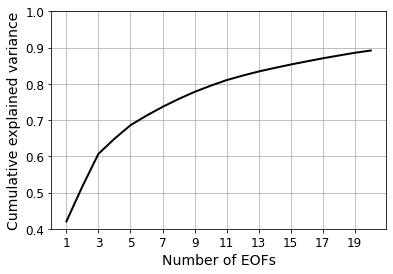

In [4]:
# make a plot of the cumulative explained variance as a function of the number of EOFs
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(1, m+1), explained_variance[:m].cumsum(), 'k-', lw=2)
ax.set_xlabel("Number of EOFs", fontsize=14)
ax.set_ylabel("Cumulative explained variance", fontsize=14)
ax.set_xticks(np.arange(1, m+1, 2))
ax.set_yticks(np.arange(0.4, 1.1, 0.1))
ax.set_ylim(0.4, 1)
ax.tick_params(labelsize=12)
ax.grid()
plt.show()
fig.savefig("./report/figures/cumulative_explained_variance.png", dpi=300, bbox_inches='tight')

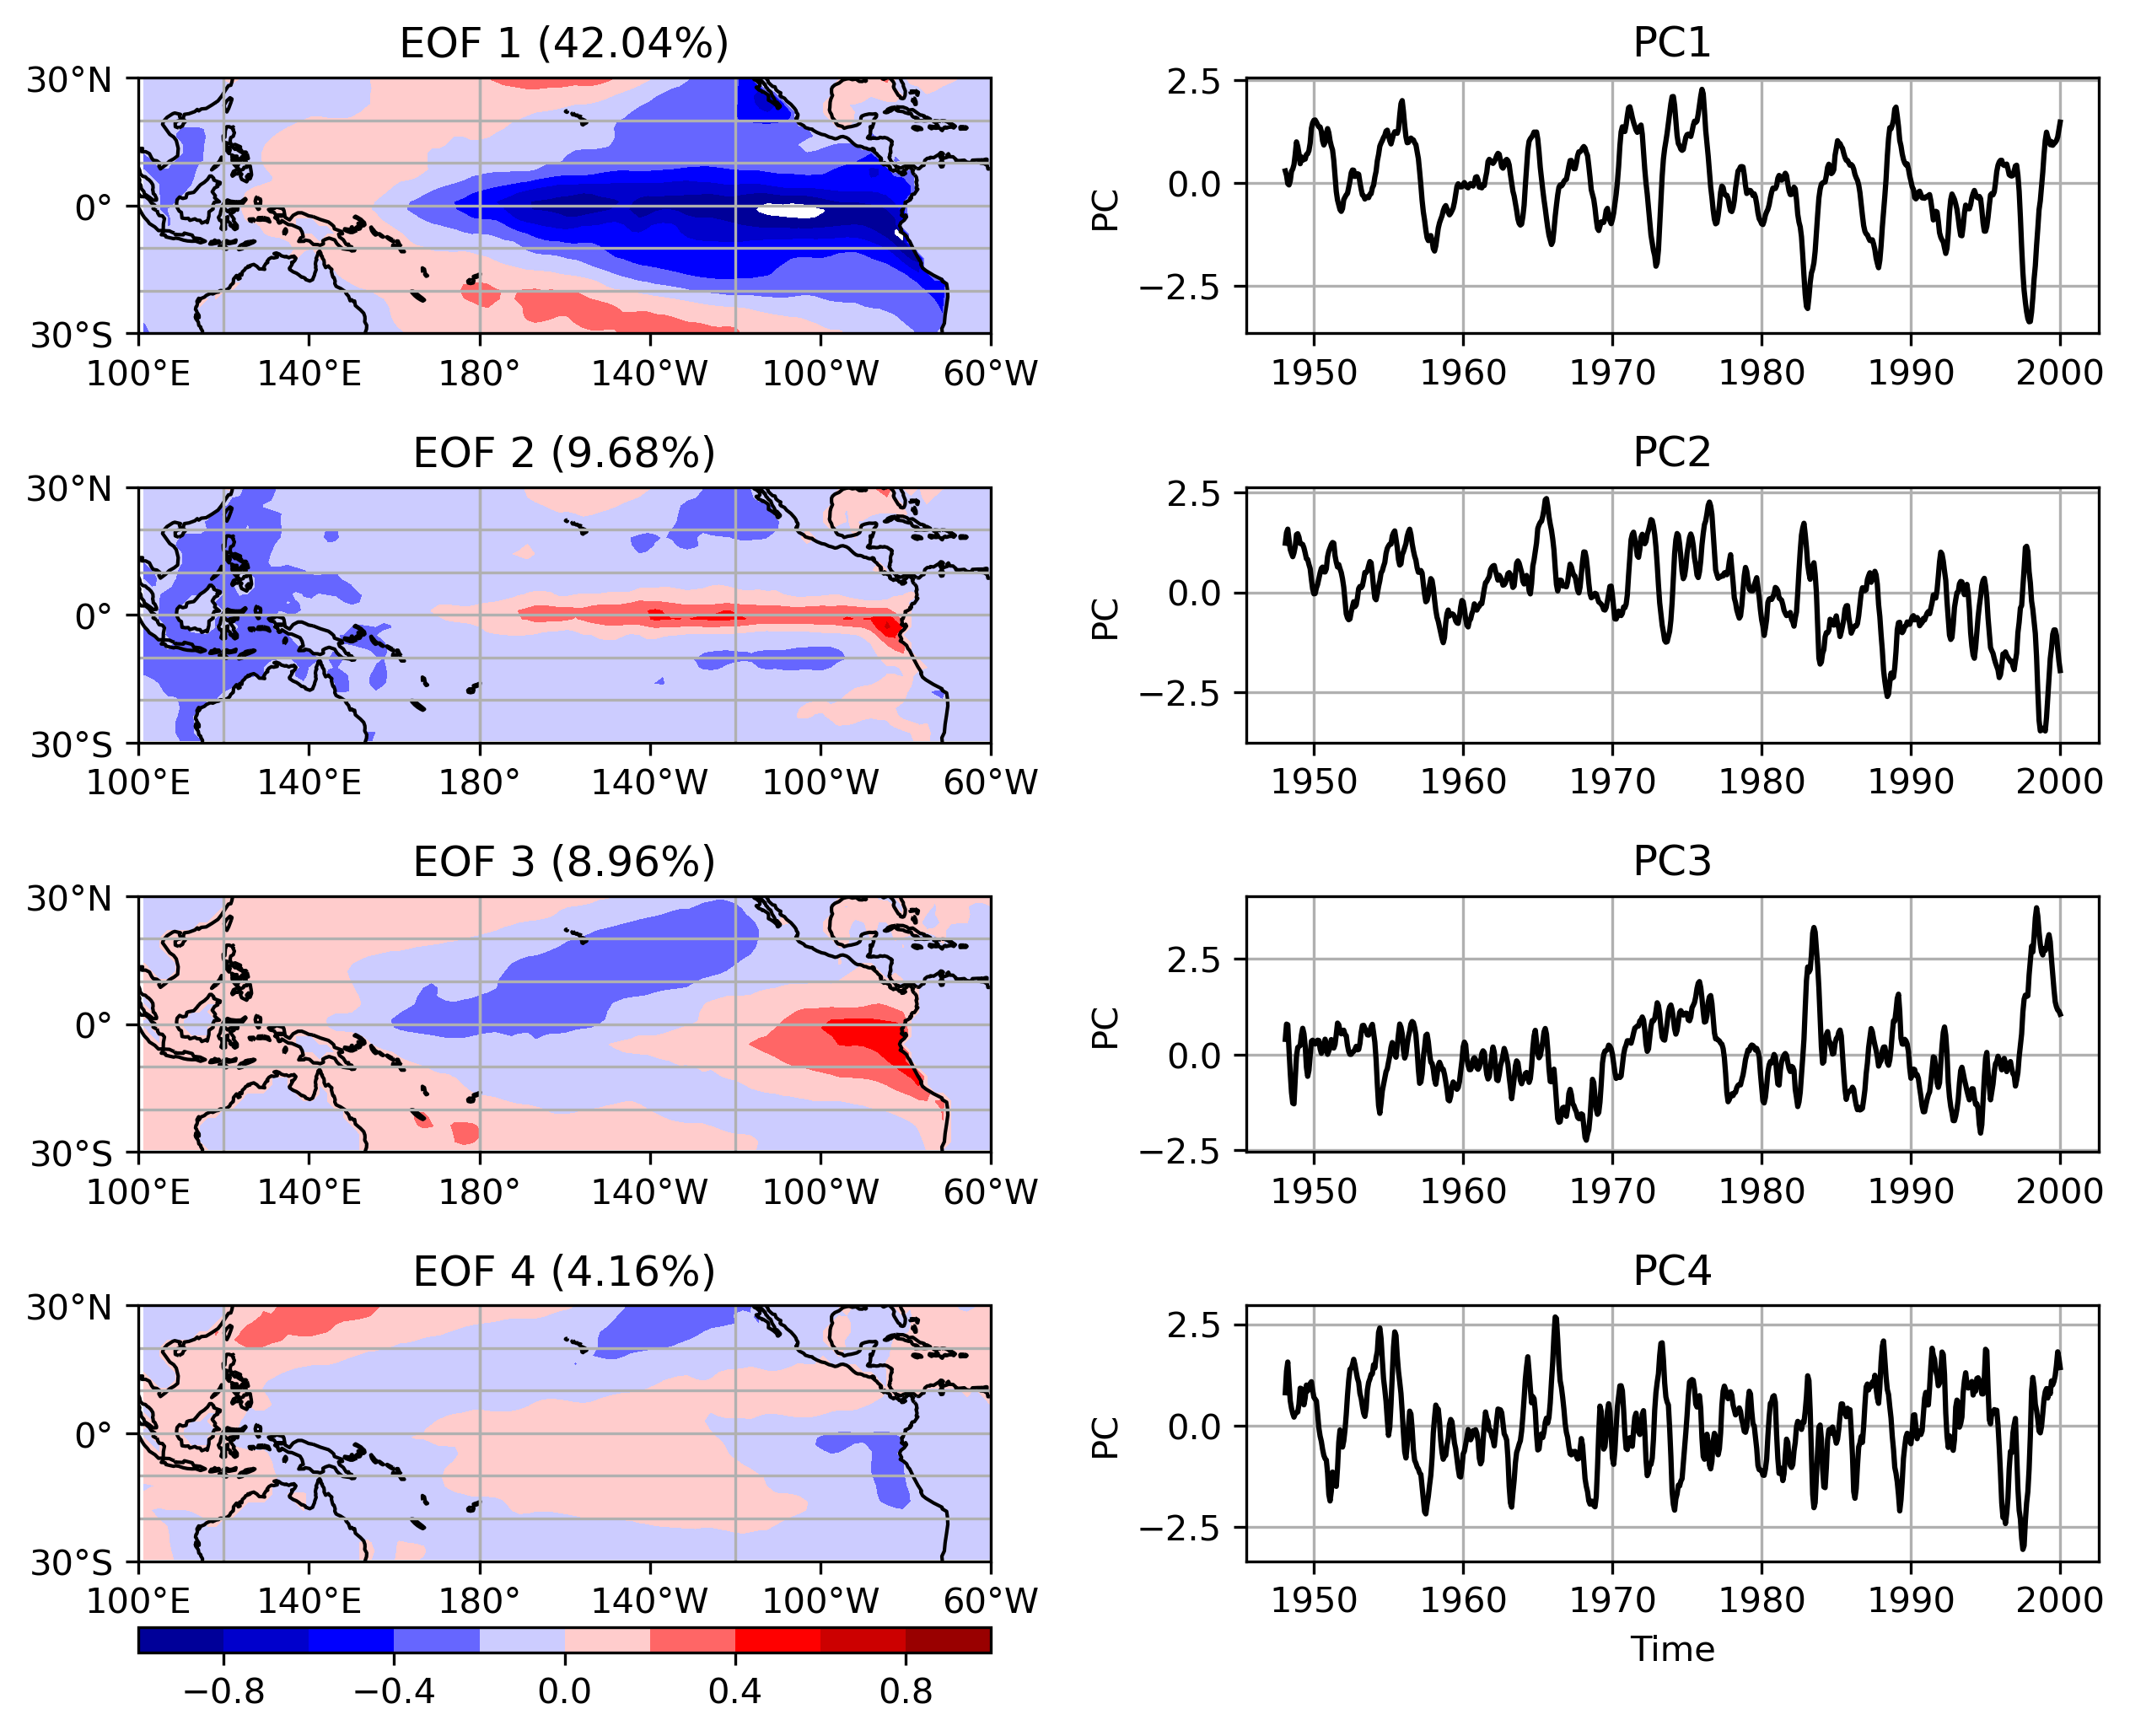

In [5]:
# plot the first 4 EOFs and PCs
# set up the figure, left column for EOFs, right column for PCs
plot_modes = 4
fig = plt.figure(figsize=(10, 10), dpi=300)
# set up the projection
projection = ccrs.PlateCarree(central_longitude=180)
# set up the axes
axes = np.empty((plot_modes, 2), dtype=object)
for i in range(plot_modes):
    axes[i,0] = fig.add_subplot(plot_modes, 2, 2*i+1, projection=projection)
    axes[i,1] = fig.add_subplot(plot_modes, 2, 2*i+2)
# cftime to float
time_fl = [t.year + t.month/12 for t in time]
# plot the first 4 EOFs
for i in range(plot_modes):
    ax = axes[i,0]
    # set extent
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    # plot the EOF
    im = ax.contourf(lon, lat, eofs[i,:,:], levels=np.linspace(-1, 1, 11), cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
    # add coastlines
    ax.coastlines()
    # add gridlines
    ax.gridlines()
    # add title
    ax.set_title(f"EOF {i+1} ({explained_variance[i]*100:.2f}%)")
    # lat and lon ticks
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.set_xticks(np.arange(lon_min, lon_max+1, 40), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # add colorbar
    if i == plot_modes - 1:
        cax = inset_axes(ax, width="100%", height="10%", loc='lower center', borderpad=-2.6)
        fig.colorbar(im, cax=cax, orientation='horizontal')
    aspect_ratio = 1/ax.get_data_ratio()
    # plot the PC
    ax = axes[i,1]
    # set aspect ratio
    ax.plot(time_fl, pcs[:,i], color='k')
    ax.set_title("PC" + str(i+1))
    if i == plot_modes-1:
        ax.set_xlabel("Time")
    ax.set_ylabel("PC")
    # add gridlines
    ax.grid()
    ax.set_aspect(60/200/ax.get_data_ratio())
# adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=-0.4)
# show and save the figure
plt.show()
fig.savefig("./report/figures/EOFs_PCs.png", dpi=300, bbox_inches='tight')

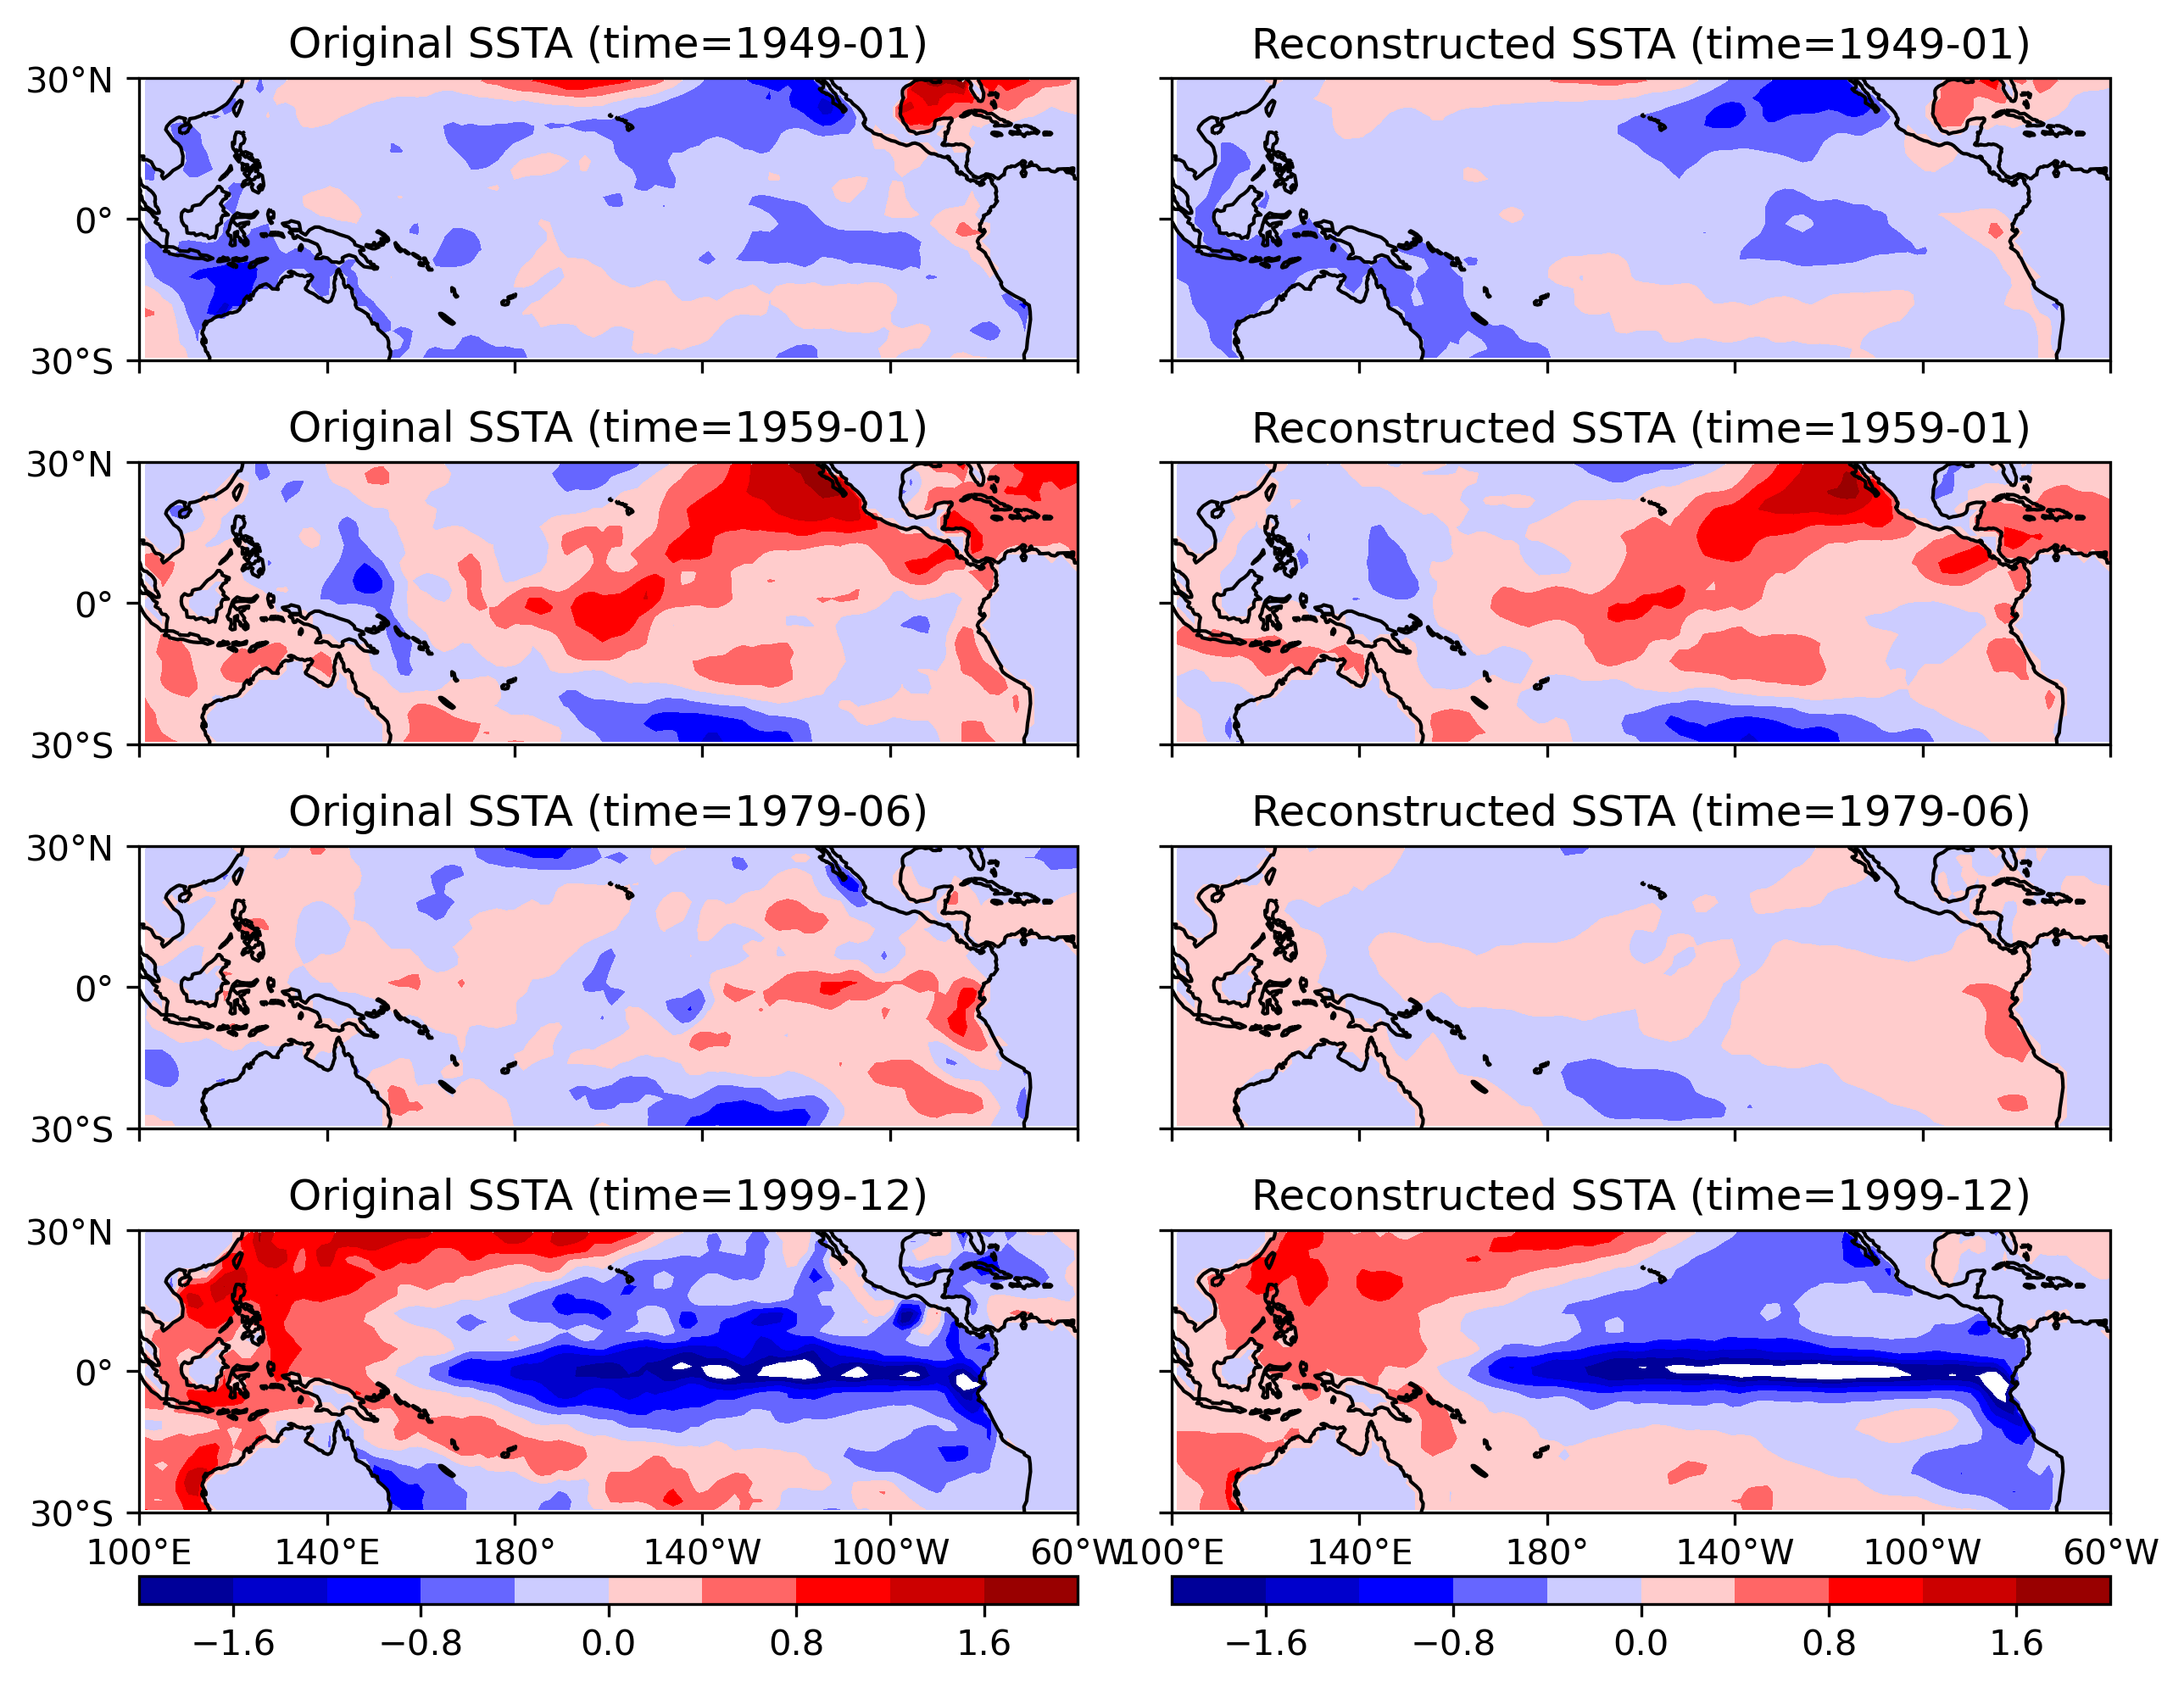

In [6]:
import cftime
# reconstruct the first m EOFs, can also use the solver.reconstructedField()
m = 10
sst_recon = pcs[:, :m] @ (eofs[:m, :, :].reshape(m, -1))
sst_recon = sst_recon.reshape(-1, grid.shape[0], grid.shape[1])
# plot the original SST and the reconstructed SST at 4 time steps
plot_step = 4
time_steps = [cftime.DatetimeGregorian(1949, 1, 1, 0, 0, 0, 0),
                cftime.DatetimeGregorian(1959, 1, 1, 0, 0, 0, 0),
                cftime.DatetimeGregorian(1979, 6, 1, 0, 0, 0, 0),
                cftime.DatetimeGregorian(1999, 12, 1, 0, 0, 0, 0)]
# get time index
time_idx = [np.where(time == t)[0][0] for t in time_steps]
fig, axes = plt.subplots(plot_step, 2, figsize=(10, 10),
                            subplot_kw={'projection': projection},
                            dpi=300)
for i in range(plot_step):
    year, month = time_steps[i].year, time_steps[i].month
    for j in range(2):
        ax = axes[i,j]
        # set extent
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        if j == 0:
            im = ax.contourf(lon, lat, sst_anom[time_idx[i],:,:], levels=np.linspace(-2, 2, 11), cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
            ax.set_title(f"Original SSTA (time={year}-{month:02d})")
        else:
            im = ax.contourf(lon, lat, sst_recon[time_idx[i],:,:], levels=np.linspace(-2, 2, 11), cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
            ax.set_title(f"Reconstructed SSTA (time={year}-{month:02d})")
        # add coastlines
        ax.coastlines()
        # lat and lon ticks
        ax.set_xticks(np.arange(lon_min, lon_max+1, 40), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
        if i == plot_step - 1:
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        else:
            # add ticks but no labels
            ax.set_xticklabels([])
        if j == 0:
            lat_formatter = LatitudeFormatter()
            ax.yaxis.set_major_formatter(lat_formatter)
        else:
            # add ticks but no labels
            ax.set_yticklabels([])
        # add colorbar
        if i == plot_step - 1:
            cax = inset_axes(ax, width="100%", height="10%", loc='lower center', borderpad=-2.6)
            fig.colorbar(im, cax=cax, orientation='horizontal')
plt.subplots_adjust(wspace=0.1, hspace=-0.5)
plt.show()
fig.savefig("./report/figures/reconstruct_ssta.png", dpi=300, bbox_inches='tight')


# Compute covariance and lag-covariance
Compute covariance and lag-covariance matrix in EOF space

In [7]:
m = 10
# coviance of the first m PCs
PC_cov = np.cov(pcs[:,0:m].T)
# lag-covariance of the first m PCs (lag=7)
PC_lag_cov = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        PC_lag_cov[i,j] = np.cov(pcs[:,i], pcs[:-7,j])[0,1]
print(PC_cov.shape)
print(PC_lag_cov.shape)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 624 and the array at index 1 has size 617